# rml (xml data) file based labeling experiments for PSG-Audio
PSG-Audio_rml_labeling.ipynb

This a collection of experiments to understand how to load and extract timing information from the .rml format used in the PSG-Audio dataset.

The major functions were combined into a single cell copied to PSG-Audio-download.ipynb

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* 



In [1]:
import os
import shutil
from shutil import unpack_archive # to unzip
import csv
import urllib.request # to get files from web w/o !wget
from datetime import date
import numpy as np
from sklearn.preprocessing import LabelEncoder # to encode strings to ints
from tabulate import tabulate # for verbose tables, showing data
import pandas as pd

In [20]:
interactive = True
verbose = True
my_dir = '.'
# setup a global readme so various methods can append info as needed
# Note:  Gets funky in interactive mode because each cell re-run appends
readme = 'This readme auto-generated by PSG-Audio_rml_labeling.ipynb\n'
readme += 'Executed on '
today = date.today()
readme += today.strftime("%B %d, %Y") + "\n"
readme += 'ref: https://github.com/imics-lab/load_data_time_series \n'

In [23]:
def get_file_from_url(full_url, fname):
    "downloads file using url and saves as passed fname, copied from download"
    ffname = os.path.join(my_dir, fname)
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local",ffname,"found, skipping download")
    else:
        print("Downloading file", full_url)
        urllib.request.urlretrieve(full_url, filename = ffname)  
if interactive:  # Note:  rmls are fast but edf takes 6+ minutes to download
    fn, furl = '1028.rml','https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842ced9b&dataSetType=personal&fileName=00001028-100507.rml'
    get_file_from_url(full_url = furl, fname = fn)

# The label information - PSG-Audio specific
After several different options, I've concluded the best plan is to build a dictionary of dictionaries that will be used in addition to the IR1 dataframes.
Specifically, there are two items to be resolved here:
* Which columns are labels not channels?   Answer: the keys of this dictionary are the labels.
* How do I know all possible labels?  Answer: You cannot derive it from the data itself - especially if you are processing by subject.   Must be determined either by a comprehensive look at all of the subjects (including the test set) or by the dataset author's information (as in the case of PSG-Audio)

In [4]:
event_map = dict(
    Cardiac = {'Normal':0,'Bradycardia':1,'Tachycardia':2,'LongRR':3,'PttDrop':4,'HeartrateDrop':5,'HeartRateRise':6,'Asystole':7,'SinusTachycardia':8,'NarrowComplexTachycardia':9,'WideComplexTachycardia':10,'AtrialFibrilation':11},
    Limb = {'Normal':0,'LegMovement':1,'AlternatingLegMuscleActivation':2,'HypnagogicFootTremor':3,'ExcessiveFreagmentaryMyoclonus':4,'RythmicMovementDisorder':5},
    Nasal = {'Normal':0, 'Snore':1 },
    Neuro = {'Normal':0,'Arousal':1},
    Respiratory = {'Normal':0,'ObstructiveApnea':1,'CentralApnea':2,'MixedApnea':3,'Hypopnea':4,'CheyneStokesRespiration':5,'PeriodicRespiration':6,'Respiratoryeffort-relatedarousal(RERA)':7},
    SpO2 = {'Normal':0,'RelativeDesaturation':1,'AbsoluteDesaturation':2})
print(event_map.keys())
print(event_map['Cardiac'])

dict_keys(['Cardiac', 'Limb', 'Nasal', 'Neuro', 'Respiratory', 'SpO2'])
{'Normal': 0, 'Bradycardia': 1, 'Tachycardia': 2, 'LongRR': 3, 'PttDrop': 4, 'HeartrateDrop': 5, 'HeartRateRise': 6, 'Asystole': 7, 'SinusTachycardia': 8, 'NarrowComplexTachycardia': 9, 'WideComplexTachycardia': 10, 'AtrialFibrilation': 11}


# Combining functions above into single cell to move over to the downloader.
Many of the development cells are below this.

In [29]:
def df_from_PSG_audio_rml(rml_fname):
    """ Extracts meta-data and builds a dataframe of labels from PSG-Audio .rml
    
    The .rml file is a form of .xml.  Here not-so-simple text commands are used
    to parse the data, first into a .csv that should be a bit more portable.
    The .csv is turned into a dataframe annot_df which is iterated over to
    build a larger label dataframe, each row = 1 second, cols = label family

    A global readme is updated and the interim .csv file is also written out.

    This cell is from PSG-Audio_rml_labeling.ipynb.  If you want to modify the
    code in it, it is probably best to go there and run/debug the functions.
    
    Args:
        rml_fname (str): The PSG-Audio .rml file name.

    Returns:
        label_df (dataframe):  Pandas dataframe, each column = 1 second, each
            row is a family type.  Event type is encoded by Type - see readme.
    """
    # begin nested helper functions
    def get_metadata_from_rml(fname):
        """extracts meta-data from the PSG-Audio .rml files, this is the data
        that is useful but not included in the signal data.   It is very
        specific to the format of PSG-Audio and employs a lot of shortcuts.
        returns int sub_num, string starting time, int duration (seconds)"""
        with open(fname, 'r') as f:
            print("opening", fname)
            dur_found = False
            for line_in in f.readlines():
                if 'AcqNumber' in line_in:
                    print(line_in)
                    acq_num = line_in.split('<')
                    acq_num = int(acq_num[1].split('>')[1])
                if 'RecordingStart' in line_in:
                    rec_start = line_in.split('<')
                    rec_start = rec_start[1].split('>')[1]
                if '<Duration>' in line_in:
                    if not dur_found:
                        dur = line_in.split('<')
                        dur = int(dur[1].split('>')[1]) 
                        dur_found = True # only want the first one
            print("acq_num", acq_num)
            return acq_num, rec_start, dur
    def convert_rml_to_csv(fname_in,fname_out):
        """reads a PSG-Audio .rml file and saves the event annotations in .csv"""
        def split_event_line(line_in):
            """Splits an Event Family .rml/XML line, drops 0.5, adds duration
            returns: string family, string type, int begin, int end"""
            line_in = line_in.replace('<Event ','')
            line_in = line_in.replace('>','')
            items = line_in.split()
            family = items[0].split('"')[1] # split again on ", wanted value is at index 1
            event = items[1].split('"')[1]
            # getting ridiculous - splitting and discarding the 0.5, half second annotations
            start = int(items[2].split('"')[1].split('.')[0])
            end = int(items[3].split('"')[1].split('.')[0])+start
            return family, event, start, end
        # ref https://www.pythontutorial.net/python-basics/python-write-csv-file/
        f_out = open(fname_out, 'w') # remember to close!
        writer = csv.writer(f_out)    # create the csv writer
        header = ['Event_Family', 'Event_Type', 'Begin', 'End']
        writer.writerow(header)
        for item in event_map.keys():
        #for item in family_list:
            with open(fname_in, 'r') as f:
                for line in f.readlines():
                    if 'Event Family="'+item+'"' in line: # the string has quotes
                        family, event, start, end = split_event_line(line)
                        row_data = [family, event, str(start),str(end)]
                        writer.writerow(row_data) # write a row to the csv file
        f_out.close()
    # def encode_psg_df(event_df): <deleted - moved to categorical labels>

    # ----Start of Main---- end helper functions
    sub_num, start_time, num_rows = get_metadata_from_rml(fname = rml_fname)
    global readme
    readme += "Subject number " + str(sub_num) + " (this is marked as acquistion number in rml)\n"
    readme += "Recording start time " + start_time + " duration " + str(num_rows) + " seconds\n"
    csv_fname = str(sub_num)+'_annot.csv'
    convert_rml_to_csv(fname_in = rml_fname, fname_out = csv_fname) 
    annot_df = pd.read_csv(csv_fname)
    # previous method failed if there were no Cardiac events (multiple subs)
    # hate to hard code the events but this seems like the safest way.
    event_df = pd.DataFrame("Normal", index=list(range(num_rows)),
                            columns=event_map.keys())
    # Yes, iterating over rows in Pandas is odd, but that is exactly what I need
    # to do.  Iterating over the annotate dfs to find the begin and end time for
    # each event so I can update (not iterate!) the event dataframe.
    # This code also seems like it could be condensed
    card_df = annot_df.loc[annot_df['Event_Family'] == 'Cardiac']
    limb_df = annot_df.loc[annot_df['Event_Family'] == 'Limb']
    resp_df = annot_df.loc[annot_df['Event_Family'] == 'Respiratory']
    spo2_df = annot_df.loc[annot_df['Event_Family'] == 'SpO2']
    nasal_df = annot_df.loc[annot_df['Event_Family'] == 'Nasal']
    neur_df = annot_df.loc[annot_df['Event_Family'] == 'Neuro']
    for index, row in card_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Cardiac']] = [row['Event_Type']]
    for index, row in limb_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Limb']] = [row['Event_Type']]
    for index, row in resp_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Respiratory']] = [row['Event_Type']]
    for index, row in spo2_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['SpO2']] = [row['Event_Type']]
    for index, row in nasal_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Nasal']] = [row['Event_Type']]
    for index, row in neur_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Neuro']] = [row['Event_Type']]
    event_df = event_df.astype('category')
    event_df.index = event_df.index.astype('int32')
    return event_df

if interactive: # Note:  edf take 6+ minutes to download, but rmls are faster
    #fn, furl = '0995.rml','https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842ced8b&dataSetType=personal&fileName=00000995-100507.rml'
    fn, furl = '0999.rml','https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842ceee9&dataSetType=personal&fileName=00000999-100507.rml'
    get_file_from_url(full_url = furl, fname = fn)
    event_df = df_from_PSG_audio_rml(rml_fname=fn)
    print('------- Contents of readme -------')
    print(readme)
    print('---------- End of readme ---------')
    display(event_df.info())
    #display(event_df.head())
    display(event_df.iloc[3750:3760])
    # move to categorical breaks this plotting function
    #event_df.iloc[3500:4500].plot(title='Label Types by Family') # earliest resp event is 3752 for sub 995
    for col in event_df:
        print('\n',col,'\n',event_df[col].value_counts(),sep='')


opening 0999.rml
      <AcqNumber>999</AcqNumber>

acq_num 999
------- Contents of readme -------
Subject number 999 (this is marked as acquistion number in rml)
Recording start time 2019-04-19T08:43:41 duration 14901 seconds

---------- End of readme ---------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14901 entries, 0 to 14900
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Cardiac      14901 non-null  category
 1   Limb         14901 non-null  category
 2   Nasal        14901 non-null  category
 3   Neuro        14901 non-null  category
 4   Respiratory  14901 non-null  category
 5   SpO2         14901 non-null  category
dtypes: category(6)
memory usage: 204.5 KB


None

,Cardiac,Limb,Nasal,Neuro,Respiratory,SpO2
3750,Normal,Normal,Normal,Arousal,Normal,Normal
3751,Normal,Normal,Normal,Arousal,Normal,Normal
3752,Normal,Normal,Normal,Arousal,Normal,Normal
3753,Normal,Normal,Normal,Arousal,Normal,Normal
3754,Normal,Normal,Normal,Arousal,Normal,Normal
3755,Normal,Normal,Normal,Arousal,Normal,Normal
3756,Normal,Normal,Normal,Normal,Normal,Normal
3757,Normal,Normal,Normal,Normal,Normal,Normal
3758,Normal,Normal,Normal,Normal,Normal,Normal
3759,Normal,Normal,Normal,Normal,Normal,Normal



Cardiac
Normal         14323
LongRR           503
Tachycardia       75
Name: Cardiac, dtype: int64

Limb
Normal         13010
LegMovement     1891
Name: Limb, dtype: int64

Nasal
Normal    14779
Snore       122
Name: Nasal, dtype: int64

Neuro
Normal     13459
Arousal     1442
Name: Neuro, dtype: int64

Respiratory
Normal              11654
ObstructiveApnea     1964
Hypopnea              798
MixedApnea            321
CentralApnea          164
Name: Respiratory, dtype: int64

SpO2
Normal                  13733
RelativeDesaturation     1168
Name: SpO2, dtype: int64


In [ ]:
# the prior code just defaulted to int64 does it make sense to reduce?
print(event_df.dtypes)
print(event_df.memory_usage())
new_df = event_df.astype('int8')
new_df.index = new_df.index.astype('int32')
print(new_df.dtypes)
print(new_df.memory_usage())

Cardiac        int64
Respiratory    int64
SpO2           int64
Neuro          int64
dtype: object
Index          671552
Cardiac        143128
Respiratory    143128
SpO2           143128
Neuro          143128
dtype: int64
Cardiac        int8
Respiratory    int8
SpO2           int8
Neuro          int8
dtype: object
Index          143128
Cardiac         17891
Respiratory     17891
SpO2            17891
Neuro           17891
dtype: int64


# Functions to process rml into a annotate csv

In [15]:
def get_metadata_from_rml(fname):
    """extracts meta-data from the PSG-Audio .rml files, this is the data
    that is useful but not included in the signal data.   It is very
    specific to the format of PSG-Audio and employs a lot of shortcuts.
    returns int sub_num, string starting time, int duration (seconds)"""
    with open(fname, 'r') as f:
        dur_found = False
        for line_in in f.readlines():
            #print(line_in,end)
            if 'AcqNumber' in line_in:
                acq_num = line_in.split('<')
                acq_num = int(acq_num[1].split('>')[1])
            if 'RecordingStart' in line_in:
                rec_start = line_in.split('<')
                rec_start = rec_start[1].split('>')[1]
            if '<Duration>' in line_in:
                if not dur_found:
                    dur = line_in.split('<')
                    dur = int(dur[1].split('>')[1]) 
                    dur_found = True # only want the first one
        return acq_num, rec_start, dur
if interactive:
    sub_num, start_time, duration = get_metadata_from_rml(fname = '1028.rml')
    print ("Subject number", sub_num, "(this is marked as acquistion number)")
    print ("Start time", start_time, "duration", round(duration/3600,2), "hours")

Subject number 1028 (this is marked as acquistion number)
Start time 2019-05-16T21:37:24 duration 6.13 hours


In [7]:
def split_event_line(line_in):
    """Splits an Event Family .rml/XML line, drops 0.5, adds duration
    returns: string family, string type, int begin, int end"""
    line_in = line_in.replace('<Event ','')
    line_in = line_in.replace('>','')
    items = line_in.split()
    family = items[0].split('"')[1] # split again on ", wanted value is at index 1
    event = items[1].split('"')[1]
    # getting ridiculous - splitting and discarding the 0.5, half second annotations
    start = int(items[2].split('"')[1].split('.')[0])
    end = int(items[3].split('"')[1].split('.')[0])+start
    return family, event, start, end
if interactive:
    line_in = '<Event Family="SpO2" Type="RelativeDesaturation" Start="12889" Duration="18" Machine="true">'
    family, event, start, end = split_event_line(line_in)
    print(family, event, start, end)
    line_in = '<Event Family="Respiratory" Type="Hypopnea" Start="17820.5" Duration="11.5">'
    family, event, start, end = split_event_line(line_in)
    print(family, event, start, end)

SpO2 RelativeDesaturation 12889 12907
Respiratory Hypopnea 17820 17831


In [14]:
def convert_rml_to_csv(fname_in,fname_out):
    """reads a PSG-Audio .rml file and saves the event annotations in .csv"""
    family_list = event_map.keys()
    #family_list = ['Cardiac','Respiratory','SpO2','Neuro','Arousal']
    # I did not include "User" events
    # ref https://www.pythontutorial.net/python-basics/python-write-csv-file/
    f_out = open(fname_out, 'w') # remember to close!
    writer = csv.writer(f_out)    # create the csv writer
    header = ['Event_Family', 'Event_Type', 'Begin', 'End']
    writer.writerow(header)
    for item in family_list:
        with open(fname_in, 'r') as f:
            for line in f.readlines():
                if 'Event Family="'+item+'"' in line: # the string has quotes
                    family, event, start, end = split_event_line(line)
                    row_data = [family, event, str(start),str(end)]
                    writer.writerow(row_data) # write a row to the csv file
    f_out.close()
if interactive:
    convert_rml_to_csv(fname_in = '1028.rml',fname_out = '1028_annot.csv')


In [15]:
temp_df = pd.read_csv('1028_annot.csv')
print(temp_df.columns)
print(temp_df['Event_Family'].unique())

# Experiments to build Pandas dataframe from the .csv
Ok, thinking this through.  There are four Event_Families which will be their own column containing the Event_Type which needs to be populated based on the begin and end.  So the resulting dataframe is 4 columns by 17891 rows (the duration value from the metadata) and to keep it reasonably small at somepoint will need to categorize so that we can get rid of strings for the Event_Type. https://pandas.pydata.org/docs/user_guide/categorical.html#categorical-memory

In [11]:
#annot_df = pd.read_csv('1028_annot.csv') # no Cardiac events for 1028
annot_df = pd.read_csv('995_annot.csv')
display(annot_df.head())
print ("Event families:")
display(annot_df['Event_Family'].unique())
print ("Event types:")
card_df = annot_df.loc[annot_df['Event_Family'] == 'Cardiac']
display(card_df['Event_Type'].unique())
resp_df = annot_df.loc[annot_df['Event_Family'] == 'Respiratory']
display(resp_df['Event_Type'].unique())
spo2_df = annot_df.loc[annot_df['Event_Family'] == 'SpO2']
display(spo2_df['Event_Type'].unique())
neur_df = annot_df.loc[annot_df['Event_Family'] == 'Neuro']
display(neur_df['Event_Type'].unique())

,Event_Family,Event_Type,Begin,End
0,Cardiac,PttDrop,466,479
1,Cardiac,PttDrop,583,596
2,Cardiac,PttDrop,857,869
3,Cardiac,Tachycardia,872,893
4,Cardiac,PttDrop,885,898


Event families:


array(['Cardiac', 'Respiratory', 'SpO2', 'Neuro'], dtype=object)

Event types:


array(['PttDrop', 'Tachycardia'], dtype=object)

array(['Hypopnea', 'ObstructiveApnea', 'MixedApnea'], dtype=object)

array(['RelativeDesaturation'], dtype=object)

array(['Arousal'], dtype=object)

In [ ]:
_,_,num_rows = get_metadata_from_rml('1028.rml')
print(num_rows)
event_df = pd.DataFrame("Normal", index=list(range(num_rows)), columns=annot_df['Event_Family'].unique())
event_df.head()

22084


,Respiratory,SpO2,Neuro
0,Normal,Normal,Normal
1,Normal,Normal,Normal
2,Normal,Normal,Normal
3,Normal,Normal,Normal
4,Normal,Normal,Normal


In [ ]:
_,_,num_rows = get_metadata_from_rml('1028.rml')
print(num_rows)
#event_df = pd.DataFrame("Normal", index=list(range(num_rows)), columns=annot_df['Event_Family'].unique())
# previous line failed if there were no Cardiac events (multiple subs)
# hate to hard code the events but this seems like the safest way.
event_df = pd.DataFrame("Normal", index=list(range(num_rows)), 
                        columns=['Cardiac','Respiratory','SpO2','Neuro'])
event_df.head()
# Yes, iterating over rows in Pandas is odd, but that is exactly what I need to
# do.  Iterating over the annotate dfs to find the begin and end time for
# each event so I can update (not iterate!) the event dataframe.
# and I am sure this could be refactored much more elegantly...
for index, row in card_df.iterrows():
    event_df.loc[row['Begin']:row['End'],['Cardiac']] = [row['Event_Type']]
display(event_df.iloc[460:470]) #should have pttDrop
display(event_df.iloc[870:880]) #should have Tachycardia
for index, row in resp_df.iterrows():
    event_df.loc[row['Begin']:row['End'],['Respiratory']] = [row['Event_Type']]
for index, row in spo2_df.iterrows():
    event_df.loc[row['Begin']:row['End'],['SpO2']] = [row['Event_Type']]
for index, row in neur_df.iterrows():
    event_df.loc[row['Begin']:row['End'],['Neuro']] = [row['Event_Type']]

22084


,Cardiac,Respiratory,SpO2,Neuro
460,Normal,Normal,Normal,Normal
461,Normal,Normal,Normal,Normal
462,Normal,Normal,Normal,Normal
463,Normal,Normal,Normal,Normal
464,Normal,Normal,Normal,Normal
465,Normal,Normal,Normal,Normal
466,Normal,Normal,Normal,Normal
467,Normal,Normal,Normal,Normal
468,Normal,Normal,Normal,Normal
469,Normal,Normal,Normal,Normal


,Cardiac,Respiratory,SpO2,Neuro
870,Normal,Normal,Normal,Normal
871,Normal,Normal,Normal,Normal
872,Normal,Normal,Normal,Normal
873,Normal,Normal,Normal,Normal
874,Normal,Normal,Normal,Normal
875,Normal,Normal,Normal,Normal
876,Normal,Normal,Normal,Normal
877,Normal,Normal,Normal,Normal
878,Normal,Normal,Normal,Normal
879,Normal,Normal,Normal,Normal


This readme auto-generated by PSG-Audio_rml_labeling.ipynb
Executed on October 09, 2022
ref: https://github.com/imics-lab/load_data_time_series 
Respiratory Encoding:{'Normal': 0, 'ObstructiveApnea': 1, 'CentralApnea': 2, 'MixedApnea': 3, 'Hypopnea': 4, 'CheyneStokesRespiration': 5, 'PeriodicRespiration': 6, 'Respiratoryeffort-relatedarousal(RERA)': 7}
Neurological Encoding:{'Normal': 0, 'Arousal': 1}
Cardiac Encoding:{'Normal': 0, 'Bradycardia': 1, 'Tachycardia': 2, 'LongRR': 3, 'PttDrop': 4, 'HeartrateDrop': 5, 'HeartRateRise': 6, 'Asystole': 7, 'SinusTachycardia': 8, 'NarrowComplexTachycardia': 9, 'WideComplexTachycardia': 10, 'AtrialFibrilation': 11}
Respiratory Encoding:{'Normal': 0, 'ObstructiveApnea': 1, 'CentralApnea': 2, 'MixedApnea': 3, 'Hypopnea': 4, 'CheyneStokesRespiration': 5, 'PeriodicRespiration': 6, 'Respiratoryeffort-relatedarousal(RERA)': 7}
Neurological Encoding:{'Normal': 0, 'Arousal': 1}
Cardiac Encoding:{'Normal': 0, 'Bradycardia': 1, 'Tachycardia': 2, 'LongRR': 

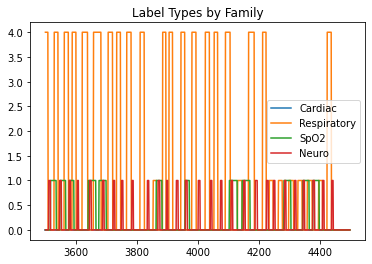

In [ ]:
def encode_psg_df(event_df):
    """Encodes event types from strings to ints using dictionary based on the
    PSG-Audio readme.  Encodings are saved in the auto-generated readme.
    Returns a dataframe with 'Respiratory', 'Neuro', 'Cardiac', 'SpO2' values
    encoded to ints."""
# a bit of context, sklearn label encoder will behave differently
# if any given subject does not have all possible values.
# acknowledgement to https://stackoverflow.com/users/10067479/ethan-kulla in
# this discussion for the general idea and starting point for code
# https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
# This really should be optimized by making a list containing the dictionaries
# but no time, just brute forcing for now.  Saved an earlier version in gutter.
# The dictionary encodings are based on the contents of the PSG-Audio readme
# There also seems to be no spaces in the .rml labels so they are deleted here.
# Torn on whether it would be better to continue numbering so there is less
# risk of confusion between event families...
    enc_Respiratory = {'Normal':0,'ObstructiveApnea':1,'CentralApnea':2,'MixedApnea':3,'Hypopnea':4,'CheyneStokesRespiration':5,'PeriodicRespiration':6,'Respiratoryeffort-relatedarousal(RERA)':7}
    enc_Neurological = {'Normal':0,'Arousal':1}
    enc_Limb = {'Normal':0,'LegMovement':1,'AlternatingLegMuscleActivation':2,'HypnagogicFootTremor':3,'ExcessiveFreagmentaryMyoclonus':4,'RythmicMovementDisorder':5}
    enc_Nasal = {'Normal':0, 'Snore':1 }
    enc_Cardiac = {'Normal':0,'Bradycardia':1,'Tachycardia':2,'LongRR':3,'PttDrop':4,'HeartrateDrop':5,'HeartRateRise':6,'Asystole':7,'SinusTachycardia':8,'NarrowComplexTachycardia':9,'WideComplexTachycardia':10,'AtrialFibrilation':11}
    enc_SpO2 = {'Normal':0,'RelativeDesaturation':1,'AbsoluteDesaturation':2}
    # Begin actual encoding
    global readme
    readme += "Respiratory Encoding:" + str(enc_Respiratory)+'\n'
    event_df['Respiratory'] = event_df['Respiratory'].map(lambda x: enc_Respiratory.get(x))
    readme += "Neurological Encoding:" + str(enc_Neurological)+'\n'
    event_df['Neuro'] = event_df['Neuro'].map(lambda x: enc_Neurological.get(x))
    readme += "Cardiac Encoding:" + str(enc_Cardiac)+'\n'
    event_df['Cardiac'] = event_df['Cardiac'].map(lambda x: enc_Cardiac.get(x))
    readme += "SpO2 Encoding:" + str(enc_SpO2)+'\n'
    event_df['SpO2'] = event_df['SpO2'].map(lambda x: enc_SpO2.get(x))
    return event_df
if interactive:
    encoded_df = encode_psg_df(event_df= event_df)
    encoded_df.iloc[3500:4500].plot(title='Label Types by Family') # earliest resp event is 3752
    print(readme)

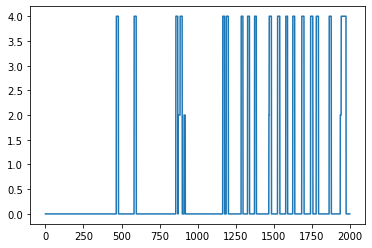

In [ ]:
event_df['Cardiac'].iloc[0:2000].plot()

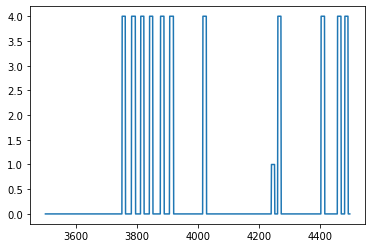

In [ ]:
event_df['Respiratory'].iloc[3500:4500].plot() # earliest resp event is 3752

# The code gutter...mostly xml and edf header experiments

In [ ]:
# This did not work for PSG-Audio.  The issue is that that the label encoder
# finds the unique entries and alphabetizes them to assign ints, hence the
# AAANormal thing.  But since these dataframes are single subject all event
# types may not be present in a given subjects record in which case the
# encoding will be different subject to subject.   Probably OK if the entire
# dataset is encoded at once, but the whole point was to try and reduce the
# size by processing each subject and making it more manageable.
# A thread on le with unknown values is here
# https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
# Convert labels to ints since space will be at a premium
# https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
# lot of good solutions - sklearn label encoder seems to be the best.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

le = LabelEncoder()
event_df['cardiac code'] = le.fit_transform(event_df['Cardiac'])
print(list(le.classes_))
readme += "Cardiac Encoding:" + str(list(le.classes_))+'\n'
display(event_df.iloc[460:470]) #should have pttDrop
display(event_df.iloc[870:880]) #should have Tachycardia

['AAANormal', 'PttDrop', 'Tachycardia']


,Cardiac,Respiratory,SpO2,Neuro,cardiac code
460,AAANormal,AAANormal,AAANormal,AAANormal,0
461,AAANormal,AAANormal,AAANormal,AAANormal,0
462,AAANormal,AAANormal,AAANormal,AAANormal,0
463,AAANormal,AAANormal,AAANormal,AAANormal,0
464,AAANormal,AAANormal,AAANormal,AAANormal,0
465,AAANormal,AAANormal,AAANormal,AAANormal,0
466,PttDrop,AAANormal,AAANormal,AAANormal,1
467,PttDrop,AAANormal,AAANormal,AAANormal,1
468,PttDrop,AAANormal,AAANormal,AAANormal,1
469,PttDrop,AAANormal,AAANormal,AAANormal,1


,Cardiac,Respiratory,SpO2,Neuro,cardiac code
870,AAANormal,AAANormal,AAANormal,AAANormal,0
871,AAANormal,AAANormal,AAANormal,AAANormal,0
872,Tachycardia,AAANormal,AAANormal,AAANormal,2
873,Tachycardia,AAANormal,AAANormal,AAANormal,2
874,Tachycardia,AAANormal,AAANormal,AAANormal,2
875,Tachycardia,AAANormal,AAANormal,AAANormal,2
876,Tachycardia,AAANormal,AAANormal,AAANormal,2
877,Tachycardia,AAANormal,AAANormal,AAANormal,2
878,Tachycardia,AAANormal,AAANormal,AAANormal,2
879,Tachycardia,AAANormal,AAANormal,AAANormal,2


,Cardiac,Respiratory,SpO2,Neuro,enc_Card
460,AAANormal,AAANormal,AAANormal,AAANormal,1
461,AAANormal,AAANormal,AAANormal,AAANormal,1
462,AAANormal,AAANormal,AAANormal,AAANormal,1
463,AAANormal,AAANormal,AAANormal,AAANormal,1
464,AAANormal,AAANormal,AAANormal,AAANormal,1
465,AAANormal,AAANormal,AAANormal,AAANormal,1
466,PttDrop,AAANormal,AAANormal,AAANormal,2
467,PttDrop,AAANormal,AAANormal,AAANormal,2
468,PttDrop,AAANormal,AAANormal,AAANormal,2
469,PttDrop,AAANormal,AAANormal,AAANormal,2


,Cardiac,Respiratory,SpO2,Neuro,enc_Card
870,AAANormal,AAANormal,AAANormal,AAANormal,1
871,AAANormal,AAANormal,AAANormal,AAANormal,1
872,Tachycardia,AAANormal,AAANormal,AAANormal,3
873,Tachycardia,AAANormal,AAANormal,AAANormal,3
874,Tachycardia,AAANormal,AAANormal,AAANormal,3
875,Tachycardia,AAANormal,AAANormal,AAANormal,3
876,Tachycardia,AAANormal,AAANormal,AAANormal,3
877,Tachycardia,AAANormal,AAANormal,AAANormal,3
878,Tachycardia,AAANormal,AAANormal,AAANormal,3
879,Tachycardia,AAANormal,AAANormal,AAANormal,3


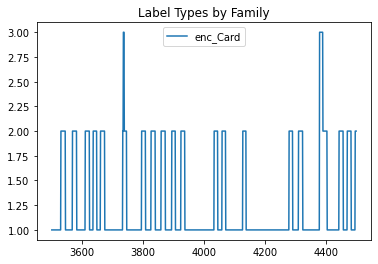

In [ ]:
# Stashing a copy of this in the gutter since it seems to work and is more
# closely aligned with the post which can handle multiple columns.
# encode values using dictionary.  sklearn label encoder will behave differently
# if any given subject does not have all possible values.
# acknowledgement to https://stackoverflow.com/users/10067479/ethan-kulla in
# this discussion for the general idea and starting point for code
# https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
cols_to_encode = ['Cardiac']
encoding_dict = dict()
for col in cols_to_encode:
    #get unique values in the column to encode
    values = event_df[col].value_counts().index.tolist()

    # create a dictionary of values and corresponding number {value, number}
    dict_values = {value: count for value, count in zip(values, range(1,len(values)+1))}

    # save the values to encode in the dictionary
    encoding_dict[col] = dict_values

    # replace the values with the corresponding number from the dictionary
    event_df['enc_Card'] = event_df[col].map(lambda x: dict_values.get(x))
display(event_df.iloc[460:470]) #should have pttDrop
display(event_df.iloc[870:880]) #should have Tachycardia
event_df.iloc[3500:4500].plot(title='Label Types by Family') # earliest resp event is 3752


In [ ]:
# for now manually upload example rml and pickled files from edf extract
# example 0995_no_sig.zip has rml, signalheader, and header but no npy data.
zip_fname = '0995_no_sig.zip'
my_dir = '.'

In [ ]:
print("Unzipping" , zip_fname)
if (os.path.exists(zip_fname)):
    shutil.unpack_archive(zip_fname,my_dir,'zip')
else:
    print("Error: ", zip_fname, " not found, exiting")

Unzipping 0995_no_sig.zip


In [9]:
# all lines containing "Event Family="
with open('1028.rml', 'r') as f:
    for line in f.readlines():
        if 'Event Family=' in line:
            print(line,end='')

         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="Gain" Start="0" Duration="0" Machine="true" OriginatedOnDevice="true">
         <Event Family="User" Type="C

In [ ]:
import pickle

In [ ]:
with open('0995_001_sig_hdr.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    sig_hdr1 = pickle.load(f)

In [ ]:
print(type(sig_hdr1))
print(sig_hdr1)
#print(sig_hdr1['label']) # doesn't work - this is a list of dictionaries

<class 'list'>
[{'label': 'EEG A1-A2', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}, {'label': 'EEG C3-A2', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}, {'label': 'EEG C4-A1', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}, {'label': 'EOG LOC-A2', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': 

In [ ]:
with open('0995_001_header.pickle', 'rb') as f1:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    header1 = pickle.load(f1)
with open('0995_002_header.pickle', 'rb') as f2:
    header2 = pickle.load(f2)
with open('0995_003_header.pickle', 'rb') as f3:
    header3 = pickle.load(f3)
with open('0995_004_header.pickle', 'rb') as f4:
    header4 = pickle.load(f4)
with open('0995_005_header.pickle', 'rb') as f5:
    header5 = pickle.load(f5)

In [ ]:
print(type(header1))
print(header1) # not much here
print(header1['startdate'])
print(header2['startdate'])
print(header3['startdate'])
print(header4['startdate'])
print(header5['startdate'])

<class 'dict'>
{'technician': '', 'recording_additional': '', 'patientname': '', 'patient_additional': '', 'patientcode': '', 'equipment': '', 'admincode': '', 'gender': '', 'startdate': datetime.datetime(2019, 4, 17, 23, 35), 'birthdate': '', 'annotations': []}
2019-04-17 23:35:00
2019-04-17 23:35:00
2019-04-17 23:35:00
2019-04-17 23:35:00
2019-04-17 23:35:00
